In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sqlalchemy import text
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))
from database.connection import get_db_manager

In [2]:
# CONFIGURACIÓN - CHAMPIONS LEAGUE
TABLE_TYPE = 'european'
COMPETITIONS = [
    'INT-Champions League'  # CORREGIDO: nombre exacto en la BD
]
SEASON = '2425'
MIN_MINUTES = 300  # Reducido para Champions (menos partidos)

# JUGADORES TARGET - BALÓN DE ORO COMPARISONS
PLAYERS = [
    {'name': 'Lamine Yamal', 'search': 'Lamine Yamal', 'pos': 'FW', 'team': 'Barcelona', 'colors': ['#A50044', '#004D98']},
    {'name': 'Ousmane Dembélé', 'search': 'Ousmane Dembélé', 'pos': 'FW', 'team': 'Paris S-G', 'colors': ['#004170', '#FF0000']},
    {'name': 'Pedri', 'search': 'Pedri', 'pos': 'MF', 'team': 'Barcelona', 'colors': ['#A50044', '#004D98']},
    {'name': 'Vitinha', 'search': 'Vitinha', 'pos': 'MF', 'team': 'Paris S-G', 'colors': ['#004170', '#FF0000']}
]

SAVE_PATH_BASE = "../images/balon_oro_champions/"
os.makedirs(SAVE_PATH_BASE, exist_ok=True)

In [3]:
# Conexión BD - CHAMPIONS LEAGUE
db = get_db_manager()

competition_list_str = "', '".join(COMPETITIONS)
query = f"""
SELECT 
    unique_player_id,
    player_name,
    team,
    competition,
    season,
    position,
    nationality,
    age,
    fbref_metrics
FROM footballdecoded.players_{TABLE_TYPE} p
WHERE p.competition IN ('{competition_list_str}')
AND p.season = '{SEASON}'
ORDER BY p.competition, p.season DESC, p.team, p.player_name
"""

df_raw = pd.read_sql(query, db.engine)
db.close()

print(f"Extraídos Champions League: {df_raw.shape[0]} registros, {df_raw.shape[1]} columnas")
df_raw.head()

2025-09-09 20:40:09,698 - database.connection - INFO - Connecting to database: localhost:5432/footballdecoded_dev
2025-09-09 20:40:09,803 - database.connection - INFO - Database connection successful


Extraídos Champions League: 878 registros, 9 columnas


,unique_player_id,player_name,team,competition,season,position,nationality,age,fbref_metrics
0,4297cac0772af3c8,Ben White,Arsenal,INT-Champions League,2425,DF,ENG,26,"{'CS': '1', 'FK': '0', 'OG': '0', '/90': '-0.1..."
1,258ed61985702bb2,Bukayo Saka,Arsenal,INT-Champions League,2425,"FW,MF",ENG,22,"{'FK': '2', 'OG': '0', 'Crs': '43', 'Fld': '17..."
2,57f809b3be3768e0,David Raya,Arsenal,INT-Champions League,2425,GK,ESP,28,"{'CS': '6', 'FK': '0', 'OG': '0', '/90': '0.38..."
3,bb58d04ee12cd7fd,Declan Rice,Arsenal,INT-Champions League,2425,MF,ENG,25,"{'FK': '3', 'OG': '0', 'Crs': '36', 'Fld': '2'..."
4,40384e981d1a5c3c,Ethan Nwaneri,Arsenal,INT-Champions League,2425,"FW,MF",ENG,17,"{'FK': '0', 'OG': '0', 'Crs': '14', 'Fld': '1'..."


In [4]:
# Verificar posiciones disponibles
positions = df_raw['position'].value_counts().sort_index()
print(f"Posiciones: {sorted(df_raw['position'].unique())}")

# Filtrar por minutos mínimos
df_filtered = df_raw[
    df_raw['fbref_metrics'].apply(
        lambda x: x.get('minutes_played', 0) if x else 0
    ) >= MIN_MINUTES
].copy()

print(f"Filtro {MIN_MINUTES}+ min Champions: {df_filtered.shape[0]} jugadores")
df_filtered.head()

Posiciones: ['DF', 'DF,FW', 'DF,MF', 'FW', 'FW,DF', 'FW,MF', 'GK', 'MF', 'MF,DF', 'MF,FW']
Filtro 300+ min Champions: 512 jugadores


,unique_player_id,player_name,team,competition,season,position,nationality,age,fbref_metrics
0,4297cac0772af3c8,Ben White,Arsenal,INT-Champions League,2425,DF,ENG,26,"{'CS': '1', 'FK': '0', 'OG': '0', '/90': '-0.1..."
1,258ed61985702bb2,Bukayo Saka,Arsenal,INT-Champions League,2425,"FW,MF",ENG,22,"{'FK': '2', 'OG': '0', 'Crs': '43', 'Fld': '17..."
2,57f809b3be3768e0,David Raya,Arsenal,INT-Champions League,2425,GK,ESP,28,"{'CS': '6', 'FK': '0', 'OG': '0', '/90': '0.38..."
3,bb58d04ee12cd7fd,Declan Rice,Arsenal,INT-Champions League,2425,MF,ENG,25,"{'FK': '3', 'OG': '0', 'Crs': '36', 'Fld': '2'..."
6,309405a8c7c3d325,Gabriel Magalhães,Arsenal,INT-Champions League,2425,DF,BRA,26,"{'FK': '0', 'OG': '0', 'Crs': '1', 'Fld': '4',..."


In [5]:
def extract_metrics(df, col_name):
    result = pd.DataFrame(index=df.index)
    
    all_keys = set()
    for _, row in df.iterrows():
        if isinstance(row[col_name], dict):
            all_keys.update(row[col_name].keys())
    
    for key in all_keys:
        values = []
        for _, row in df.iterrows():
            if isinstance(row[col_name], dict) and key in row[col_name]:
                raw_value = row[col_name][key]
                converted_value = _convert_to_float(raw_value)
                values.append(converted_value)
            else:
                values.append(np.nan)
        
        valid_count = pd.Series(values).notna().sum()
        if valid_count >= 5:
            result[key] = values
    
    return result

def _convert_to_float(value):
    if isinstance(value, (int, float)):
        return float(value)
    
    if value is None or pd.isna(value):
        return np.nan
    
    if isinstance(value, str):
        if value.strip() == '':
            return np.nan
        
        if value.lower().strip() in ['nan', 'none', 'null', '-']:
            return np.nan
        
        try:
            return float(value)
        except (ValueError, TypeError):
            return np.nan
    
    return np.nan

In [6]:
# Extraer métricas numéricas - SOLO FBREF para Champions
fbref_nums = extract_metrics(df_filtered, 'fbref_metrics')
print(f"FBref Champions: {fbref_nums.shape[1]} métricas disponibles")

FBref Champions: 185 métricas disponibles


In [7]:
# Métricas a excluir de per90
exclude_per90 = {
    'pass_completion_pct', 'shots_on_target_pct', 'Take-Ons_Succ%', 'Take-Ons_Tkld%', 
    'Aerial Duels_Won%', 'Challenges_Tkl%', 'Save%', 'Launched_Cmp%', 'Crosses_Stp%',
    'shots_per_90', 'GA90', 'GCA_GCA90', 'SCA_SCA90', 'Team Success_+/-90', 'SoT/90',
    'npxG/Sh', 'xG+xAG', 'non_penalty_xG_plus_xAG', 'avg_shot_distance', 'minutes_per_match',
    'Passes_AvgLen', 'Goal Kicks_AvgLen', 'Starts_Mn/Start', 'Subs_Mn/Sub', 'Min%',
    'matches_played', 'matches_started', 'minutes_played', 'wins', 'draws', 'losses'
}

# Calcular per90 FBref
fbref_per90 = fbref_nums.loc[:, ~fbref_nums.columns.isin(exclude_per90)]
fbref_per90 = (fbref_per90.div(fbref_nums['minutes_played'], axis=0) * 90).round(3)
fbref_per90.columns = [f'{col}_per90' for col in fbref_per90.columns]

print(f"Per90 Champions: {fbref_per90.shape[1]} métricas")

# COMBINAR todas las métricas
all_metrics = pd.concat([fbref_nums, fbref_per90], axis=1)

Per90 Champions: 154 métricas


In [8]:
# Calcular percentiles
all_percentiles = all_metrics.rank(pct=True) * 98 + 1
all_percentiles = all_percentiles.round(0).astype('Int64')
all_percentiles.columns = [f'{col}_pct' for col in all_percentiles.columns]

print(f"Métricas totales Champions: {all_metrics.shape[1]}")
print(f"Percentiles totales Champions: {all_percentiles.shape[1]}")

Métricas totales Champions: 339
Percentiles totales Champions: 339


In [9]:
# DataFrame final consolidado
base_cols = ['unique_player_id', 'player_name', 'team', 'competition', 'season', 'position']

df_final = pd.concat([
    df_filtered[base_cols],
    all_metrics,
    all_percentiles
], axis=1)

print(f"DataFrame final Champions: {df_final.shape[0]} filas, {df_final.shape[1]} columnas")

# Limpieza de Series anidados
def clean_series_values(df):
    for col in df.columns:
        series_mask = df[col].apply(lambda x: isinstance(x, pd.Series))
        
        if series_mask.any():
            print(f"Limpiando Series en: {col}")
            df[col] = df[col].apply(
                lambda x: x.iloc[0] if isinstance(x, pd.Series) and not x.empty else x
            )
    return df

df_final = clean_series_values(df_final)

# Eliminar columnas problemáticas
problem_cols = ['shots_on_target_pct']
df_final = df_final.drop(columns=[col for col in problem_cols if col in df_final.columns])

print(f"Limpieza completada Champions: {df_final.shape[1]} columnas finales")

DataFrame final Champions: 512 filas, 684 columnas
Limpiando Series en: shots_on_target_pct
Limpiando Series en: shots_on_target_pct
Limpieza completada Champions: 682 columnas finales


In [10]:
# EXPLORACIÓN MÉTRICAS DISPONIBLES - CHAMPIONS LEAGUE
print("MÉTRICAS FBREF CHAMPIONS DISPONIBLES:")
print("=" * 50)
fbref_sorted = sorted(list(fbref_nums.columns))
for i, metric in enumerate(fbref_sorted, 1):
    print(f"{i:2d}. {metric}")

print(f"\nTotal FBref Champions: {len(fbref_sorted)}")

print("\nMÉTRICAS PER90 CHAMPIONS DISPONIBLES:")
print("=" * 50)
per90_sorted = sorted([col for col in all_metrics.columns if col.endswith('_per90')])
for i, metric in enumerate(per90_sorted[:20], 1):
    print(f"{i:2d}. {metric}")
if len(per90_sorted) > 20:
    print(f"... y {len(per90_sorted) - 20} más")

print(f"\nTotal Per90 Champions: {len(per90_sorted)}")

MÉTRICAS FBREF CHAMPIONS DISPONIBLES:
 1. /90
 2. 2CrdY
 3. A-xAG
 4. Aerial Duels_Lost
 5. Aerial Duels_Won
 6. Aerial Duels_Won%
 7. Blocks_Blocks
 8. Blocks_Pass
 9. Blocks_Sh
10. CS
11. CS%
12. Carries_1/3
13. Carries_CPA
14. Carries_Carries
15. Carries_Dis
16. Carries_Mis
17. Carries_PrgC
18. Carries_PrgDist
19. Carries_TotDist
20. Challenges_Att
21. Challenges_Lost
22. Challenges_Tkl
23. Challenges_Tkl%
24. Corner Kicks_In
25. Corner Kicks_Out
26. Corner Kicks_Str
27. Crosses_Opp
28. Crosses_Stp
29. Crosses_Stp%
30. Crs
31. CrsPA
32. FK
33. Fld
34. Fls
35. G+A-PK
36. G-xG
37. GA90
38. GCA Types_Def
39. GCA Types_Fld
40. GCA Types_PassDead
41. GCA Types_PassLive
42. GCA Types_Sh
43. GCA Types_TO
44. GCA_GCA
45. GCA_GCA90
46. Goal Kicks_Att
47. Goal Kicks_AvgLen
48. Goal Kicks_Launch%
49. Goals_CK
50. Goals_FK
51. Goals_GA
52. Goals_OG
53. Goals_PKA
54. Launched_Att
55. Launched_Cmp
56. Launched_Cmp%
57. Min%
58. OG
59. Off
60. Outcomes_Blocks
61. Outcomes_Cmp
62. Outcomes_Off
63. 

In [11]:
# Buscar jugadores - BALÓN DE ORO TARGET PLAYERS CHAMPIONS
player_ids = {}

for player in PLAYERS:
    search_results = df_filtered[
        df_filtered['player_name'].str.contains(player['search'], case=False, na=False)
    ]
    
    print(f"\n{player['name']} (búsqueda: '{player['search']}'):")
    if len(search_results) > 0:
        for _, p in search_results.iterrows():
            print(f"  {p['unique_player_id']} - {p['player_name']} ({p['team']}, {p['competition']}, {p['position']})")
            
            if player['name'] not in player_ids:
                player_ids[player['name']] = p['unique_player_id']
    else:
        print(f"  No encontrado en Champions League")

print(f"\nJugadores encontrados en Champions: {len(player_ids)}/{len(PLAYERS)}")

# Show found players
for name, player_id in player_ids.items():
    player_data = df_filtered[df_filtered['unique_player_id'] == player_id].iloc[0]
    print(f"{name}: {player_data['team']} ({player_data['competition']})")


Lamine Yamal (búsqueda: 'Lamine Yamal'):
  21297d2f630ee776 - Lamine Yamal (Barcelona, INT-Champions League, FW)

Ousmane Dembélé (búsqueda: 'Ousmane Dembélé'):
  1ee9a1fbdfc47511 - Ousmane Dembélé (Paris S-G, INT-Champions League, FW)

Pedri (búsqueda: 'Pedri'):
  8c50fb1a1662d90f - Pedri (Barcelona, INT-Champions League, MF)

Vitinha (búsqueda: 'Vitinha'):
  9c2101225992502f - Vitinha (Paris S-G, INT-Champions League, MF)

Jugadores encontrados en Champions: 4/4
Lamine Yamal: Barcelona (INT-Champions League)
Ousmane Dembélé: Paris S-G (INT-Champions League)
Pedri: Barcelona (INT-Champions League)
Vitinha: Paris S-G (INT-Champions League)


In [12]:
# PLAYER IDs - BALÓN DE ORO COMPARISONS CHAMPIONS
# Run search_players cell first to get the IDs, then set them here manually

# Comparison 1: Lamine Yamal vs Ousmane Dembélé  
LAMINE_ID = '21297d2f630ee776'  # To be filled after search
DEMBELE_ID = '1ee9a1fbdfc47511'  # To be filled after search

# Comparison 2: Pedri vs Vitinha
PEDRI_ID = '8c50fb1a1662d90f'   # To be filled after search  
VITINHA_ID = '9c2101225992502f' # To be filled after search

print("Execute the search_players cell above first, then fill in these IDs manually")

Execute the search_players cell above first, then fill in these IDs manually


In [13]:
# BALÓN DE ORO - COMPREHENSIVE ANALYSIS PROFILES CHAMPIONS

# DEFENSA (10 métricas) - Defensive contributions
defensa_metrics = [
    'Tkl+Int_per90', 'interceptions_per90', 'Challenges_Tkl%', 'Blocks_Pass_per90',
    'Recov_per90', 'Fld_per90', 'Tackles_Att 3rd_per90', 'Progression_PrgC_per90',
    'SCA Types_Def_per90', 'Challenges_Att_per90'
]

defensa_titles = [
    'Tackles + Interceptions', 'Interceptions', 'Tackle Success %', 'Pass Blocks',
    'Ball Recoveries', 'Fouls Drawn', 'High Pressing', 'Defensive Carries',
    'Defensive Actions (SCA)', 'Defensive Challenges'
]

# CREACIÓN Y JUEGO (10 métricas) - Creation & Playmaking  
creacion_metrics = [
    'progressive_passes_per90', 'key_passes_per90', 'expected_assists_per90', 'SCA_SCA90',
    'GCA_GCA90', 'passes_penalty_area_per90', 'Carries_PrgC_per90', 'passes_final_third_per90',
    'pass_completion_pct', 'assists_per90'
]

creacion_titles = [
    'Progressive Passes', 'Key Passes', 'Expected Assists', 'Shot Creating Actions',
    'Goal Creating Actions', 'Box Passes', 'Progressive Carries', 'Final Third Passes',
    'Pass Accuracy %', 'Assists'
]

# ATAQUE (10 métricas) - Attack & Finishing  
ataque_metrics = [
    'expected_goals_per90', 'goals_per90', 'shots_per90', 'shots_on_target_per90',
    'Take-Ons_Succ_per90', 'Touches_Att Pen_per90', 'npxG/Sh', 'G-xG_per90',
    'avg_shot_distance', 'Crs_per90'
]

ataque_titles = [
    'Expected Goals', 'Goals', 'Shots', 'Shots on Target',
    'Dribbles', 'Touches in Box', 'npxG per Shot', 'Goals - xG',
    'Shot Distance', 'Crosses'
]

# Verificar longitud
balon_oro_configs = [
    ('DEFENSA', defensa_metrics, defensa_titles),
    ('CREACIÓN', creacion_metrics, creacion_titles),
    ('ATAQUE', ataque_metrics, ataque_titles)
]

for profile, metrics, titles in balon_oro_configs:
    if len(metrics) == 10 and len(titles) == 10:
        print(f"{profile}: ✓ {len(metrics)} métricas configuradas")
    else:
        print(f"{profile}: ✗ {len(metrics)} métricas, {len(titles)} títulos")

DEFENSA: ✓ 10 métricas configuradas
CREACIÓN: ✓ 10 métricas configuradas
ATAQUE: ✓ 10 métricas configuradas


=== BALÓN DE ORO COMPARISONS - CHAMPIONS LEAGUE ===

=== GENERANDO LAMINE_VS_DEMBELE_UCL - CHAMPIONS ====
Lamine Yamal vs Ousmane Dembélé
Posiciones: Lamine Yamal = FW, Ousmane Dembélé = FW
Dataset Champions: 161 FW Players
Players in Champions dataset: Lamine Yamal=True, Ousmane Dembélé=True

  Generando DEFENSA Champions...
DEBUG Player 1 - Team: 'Barcelona', team_logos keys: ['Barcelona', 'Paris S-G']
DEBUG P1 - Loading logo from: ../caras/extras/Lamine.png
DEBUG P1 - Logo loaded successfully for Barcelona
    ✗ Error DEFENSA Champions: 'league'
    Debug traceback: Traceback (most recent call last):
  File "/home/oriol/.local/lib/python3.10/site-packages/pandas/core/indexes/base.py", line 3653, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas/_libs/index.pyx", line 147, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 176, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 7080, in pan

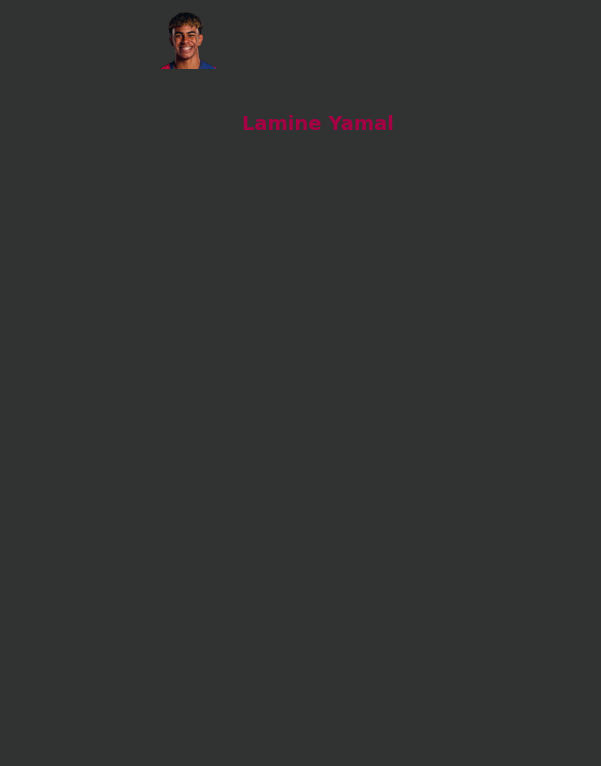

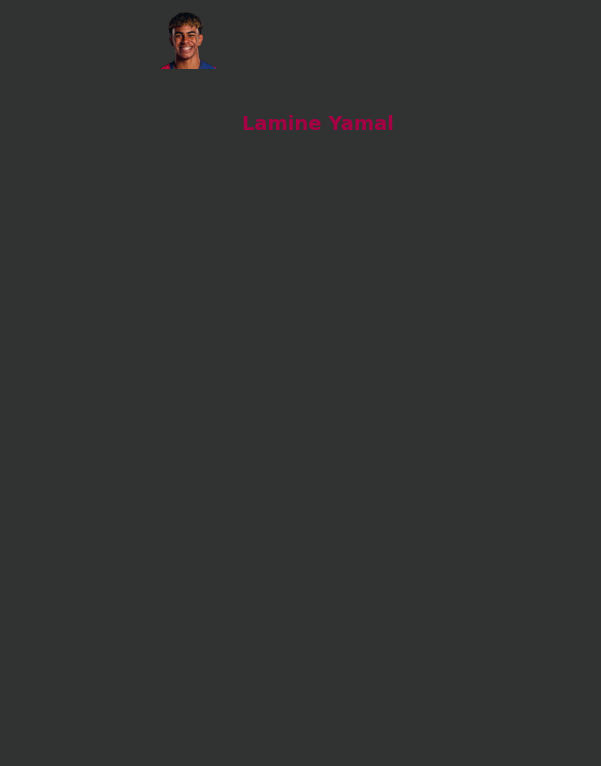

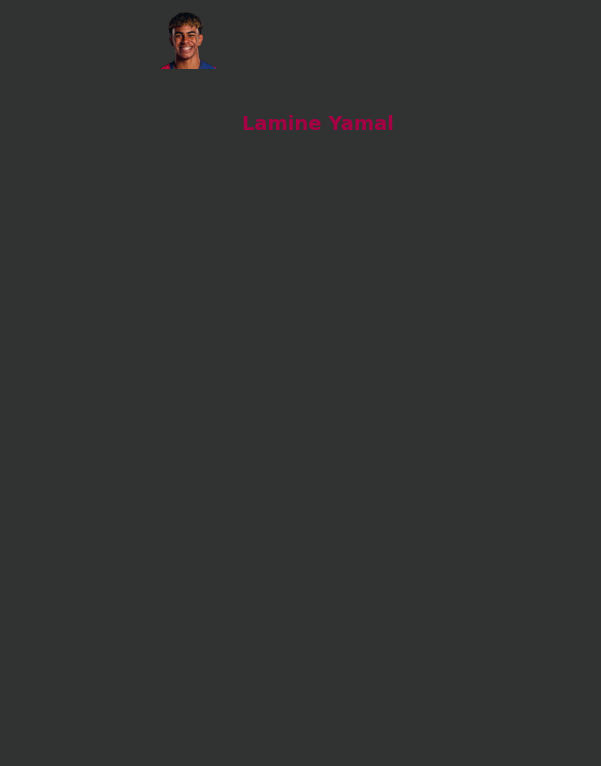

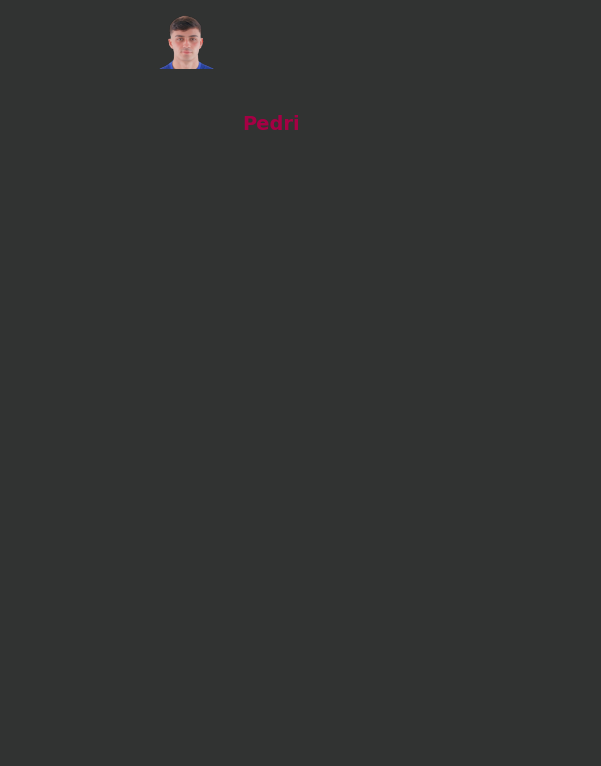

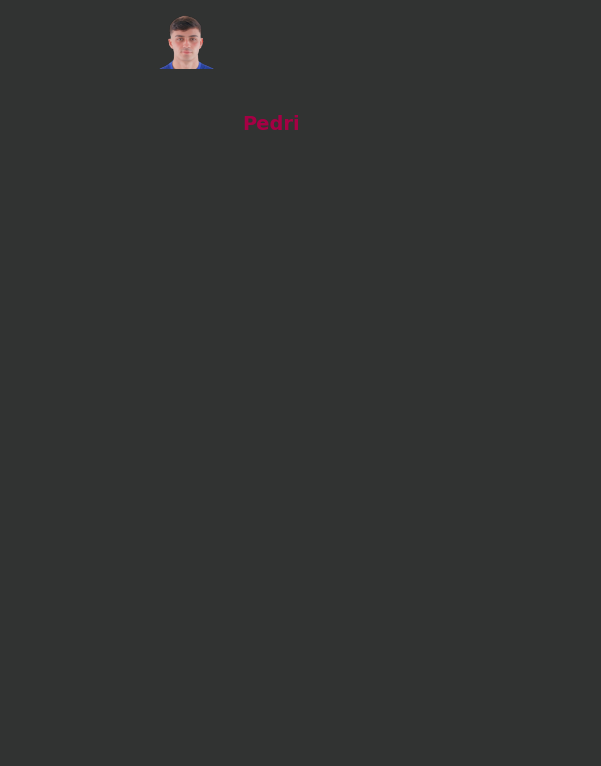

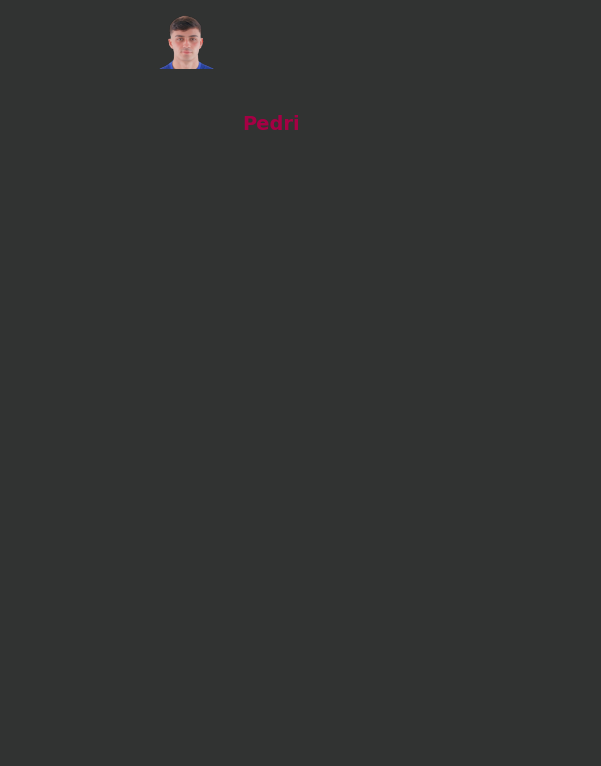

In [14]:
# BALÓN DE ORO COMPREHENSIVE COMPARISONS - 6 TOTAL GRAPHICS - CHAMPIONS LEAGUE

from viz.swarm_radar import create_player_radar
from viz.stats_radar import create_stats_table, combine_radar_and_table
from IPython.display import Image as IPImage, display

def generate_balon_oro_comparison_champions(player1_id, player2_id, name1, name2, team1, team2, 
                                          color1, color2, face1, face2, comparison_name):
    """Generate 3 comprehensive comparison charts for Balón de Oro analysis - Champions League"""
    
    if not player1_id or not player2_id:
        print(f"Saltando {comparison_name}: faltan IDs de jugadores")
        return []
    
    print(f"\n=== GENERANDO {comparison_name.upper()} - CHAMPIONS ====")
    print(f"{name1} vs {name2}")
    
    # Get player data to determine positions
    player1_data = df_final[df_final['unique_player_id'] == player1_id]
    player2_data = df_final[df_final['unique_player_id'] == player2_id]
    
    if player1_data.empty or player2_data.empty:
        print(f"ERROR: No se encontraron datos para los jugadores en Champions")
        print(f"Player1 ({player1_id}): {'Found' if not player1_data.empty else 'NOT FOUND'}")
        print(f"Player2 ({player2_id}): {'Found' if not player2_data.empty else 'NOT FOUND'}")
        return []
    
    pos1 = player1_data['position'].iloc[0]
    pos2 = player2_data['position'].iloc[0]
    
    print(f"Posiciones: {name1} = {pos1}, {name2} = {pos2}")
    
    # Determine comparison dataset based on positions
    if 'FW' in pos1 or 'FW' in pos2:
        comparison_df = df_final[df_final['position'].str.contains('FW', na=False)].copy()
        position_label = "FW Players"
    elif 'MF' in pos1 or 'MF' in pos2:
        comparison_df = df_final[df_final['position'].str.contains('MF', na=False)].copy()
        position_label = "MF Players"
    else:
        # Fallback to all outfield players
        comparison_df = df_final[~df_final['position'].str.startswith('GK')].copy()
        position_label = "Outfield Players"
    
    print(f"Dataset Champions: {comparison_df.shape[0]} {position_label}")
    
    # Verify players are in the filtered dataset
    p1_in_dataset = player1_id in comparison_df['unique_player_id'].values
    p2_in_dataset = player2_id in comparison_df['unique_player_id'].values
    
    print(f"Players in Champions dataset: {name1}={p1_in_dataset}, {name2}={p2_in_dataset}")
    
    if not p1_in_dataset or not p2_in_dataset:
        print(f"ERROR: Jugadores no encontrados en el dataset Champions filtrado")
        return []
    
    team_colors = [color1, color2]
    team_logos = {team1: face1, team2: face2}
    
    generated_images = []
    
    # Generate 3 profile comparisons
    for profile_name, metrics, titles in balon_oro_configs:
        profile_safe = profile_name.lower().replace('ó', 'o').replace(' ', '_')
        combined_path = f"{SAVE_PATH_BASE}{comparison_name}_{profile_safe}_combined.png"
        
        try:
            print(f"\n  Generando {profile_name} Champions...")
            
            # 1. Radar Chart
            create_player_radar(
                df_data=comparison_df,
                player_1_id=player1_id,
                player_2_id=player2_id,
                metrics=metrics,
                metric_titles=titles,
                team_colors=team_colors,
                save_path=f"{SAVE_PATH_BASE}{comparison_name}_{profile_safe}_radar.png",
                use_swarm=False,
                show_plot=False
            )
            
            # 2. Stats Table
            create_stats_table(
                df_data=comparison_df,
                player_1_id=player1_id,
                player_2_id=player2_id,
                metrics=metrics,
                metric_titles=titles,
                team_colors=team_colors,
                team_logos=team_logos,
                save_path=f"{SAVE_PATH_BASE}{comparison_name}_{profile_safe}_table.png",
                footer_text=f"Stats (x90 min) & Percentiles vs Champions League {position_label} ({MIN_MINUTES}+ mins) 2024/25",
                show_plot=False
            )
            
            # 3. Combined Image  
            combine_radar_and_table(
                radar_path=f"{SAVE_PATH_BASE}{comparison_name}_{profile_safe}_radar.png",
                table_path=f"{SAVE_PATH_BASE}{comparison_name}_{profile_safe}_table.png",
                output_path=combined_path
            )
            
            generated_images.append(combined_path)
            print(f"    ✓ {profile_name} Champions completado")
            
        except Exception as e:
            print(f"    ✗ Error {profile_name} Champions: {str(e)}")
            # More detailed error info
            import traceback
            print(f"    Debug traceback: {traceback.format_exc()}")
    
    print(f"=== {comparison_name.upper()} CHAMPIONS COMPLETADO ====")
    return generated_images


# GENERATE ALL COMPARISONS - CHAMPIONS LEAGUE
print("=== BALÓN DE ORO COMPARISONS - CHAMPIONS LEAGUE ===")
all_generated_images = []

# Comparison 1: Lamine vs Dembélé
if LAMINE_ID and DEMBELE_ID:
    lamine_images = generate_balon_oro_comparison_champions(
        player1_id=LAMINE_ID, 
        player2_id=DEMBELE_ID,
        name1='Lamine Yamal', 
        name2='Ousmane Dembélé',
        team1='Barcelona', 
        team2='Paris S-G',
        color1='#A50044', 
        color2='#004170',
        face1='../caras/extras/Lamine.png', 
        face2='../caras/extras/Dembele.png',
        comparison_name='Lamine_vs_Dembele_UCL'
    )
    all_generated_images.extend(lamine_images)
else:
    print("Saltando Lamine vs Dembélé: faltan IDs en Champions")

# Comparison 2: Pedri vs Vitinha  
if PEDRI_ID and VITINHA_ID:
    pedri_images = generate_balon_oro_comparison_champions(
        player1_id=PEDRI_ID,
        player2_id=VITINHA_ID, 
        name1='Pedri',
        name2='Vitinha',
        team1='Barcelona',
        team2='Paris S-G',
        color1='#A50044',
        color2='#004170', 
        face1='../caras/extras/Pedri.png',
        face2='../caras/extras/Vitinha.png',
        comparison_name='Pedri_vs_Vitinha_UCL'
    )
    all_generated_images.extend(pedri_images)
else:
    print("Saltando Pedri vs Vitinha: faltan IDs en Champions")

print(f"\n🏆 BALÓN DE ORO CHAMPIONS ANALYSIS COMPLETED - {len(all_generated_images)} GRAPHICS GENERATED 🏆")

# DISPLAY ALL GENERATED IMAGES
if all_generated_images:
    print(f"\n📊 MOSTRANDO {len(all_generated_images)} GRÁFICOS CHAMPIONS GENERADOS:")
    for i, image_path in enumerate(all_generated_images, 1):
        print(f"\n{i}. {image_path.split('/')[-1]}")
        display(IPImage(image_path))